In [1]:
# !wget — no-check-certificate \
#  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
#  -O /tmp/sunspots.csv

--2021-01-20 11:17:35--  http://xn--8ug/
Resolving xn--8ug (xn--8ug)... failed: Temporary failure in name resolution.
wget: unable to resolve host address ‘xn--8ug’
--2021-01-20 11:17:38--  http://no-check-certificate/
Resolving no-check-certificate (no-check-certificate)... failed: Temporary failure in name resolution.
wget: unable to resolve host address ‘no-check-certificate’
--2021-01-20 11:17:39--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.184.176, 216.58.215.144, 172.217.17.16, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.184.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  10.9KB/s    in 6.4s    

2021-01-20 11:17:51 (10.9 KB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]

FINISHED --2021-01-20 11

In [17]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from IPython.display import display

time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        sunspots.append(float(row[2]))
        time_step.append(int(row[0]))
        
                
series = np.array(sunspots)
time = np.array(time_step)
print('series: {}'.format(series[:5]))
print('time: {}'.format(time[:5]))

series: [ 96.7 104.3 116.7  92.8 141.7]
time: [0 1 2 3 4]


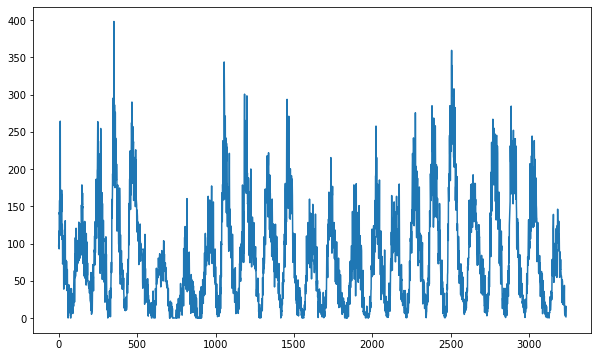

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(time, series)

plt.show()

In [19]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

In [21]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
       
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    
    return ds.batch(batch_size).prefetch(1)

In [22]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

shuffle_buffer_size = 1000
window_size = 64
batch_size = 5
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

display(x_train.shape)
display(train_set)

(3000,)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>

In [23]:
next(iter(train_set))

(<tf.Tensor: shape=(256, 64, 1), dtype=float64, numpy=
 array([[[ 73.8],
         [ 72.7],
         [ 64.7],
         ...,
         [  3. ],
         [  4.3],
         [  8. ]],
 
        [[  9.5],
         [ 13.3],
         [  4.3],
         ...,
         [  6.5],
         [ 13.2],
         [ 16.8]],
 
        [[ 53.3],
         [ 78.7],
         [ 67. ],
         ...,
         [140.5],
         [136.7],
         [123.3]],
 
        ...,
 
        [[104.3],
         [116.7],
         [ 92.8],
         ...,
         [  2.8],
         [ 22.8],
         [ 34.5]],
 
        [[  5. ],
         [  5.5],
         [  6.7],
         ...,
         [112.8],
         [ 97.5],
         [169. ]],
 
        [[ 83.3],
         [118.3],
         [ 98.8],
         ...,
         [ 43.7],
         [ 50. ],
         [ 63.5]]])>,
 <tf.Tensor: shape=(256, 64, 1), dtype=float64, numpy=
 array([[[ 72.7],
         [ 64.7],
         [ 38.7],
         ...,
         [  4.3],
         [  8. ],
         [  7.3]],
 

In [25]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=60, kernel_size=5,
    strides=1, padding="causal", activation="relu", input_shape=[None, 1]),
    
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.LSTM(60, return_sequences=True),
    
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    
    tf.keras.layers.Lambda(lambda x: x * 400)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 60)          360       
_________________________________________________________________
lstm (LSTM)                  (None, None, 60)          29040     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 60)          29040     
_________________________________________________________________
dense (Dense)                (None, None, 30)          1830      
_________________________________________________________________
dense_1 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           11        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0

In [26]:
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

history = model.fit(train_set,epochs=500)

Epoch 1/500
12/12 [==============================] - 5s 391ms/step - loss: 49.2724 - mae: 49.7701
Epoch 2/500
12/12 [==============================] - 5s 407ms/step - loss: 32.2401 - mae: 32.7353
Epoch 3/500
12/12 [==============================] - 4s 361ms/step - loss: 27.0728 - mae: 27.5676
Epoch 4/500
12/12 [==============================] - 5s 376ms/step - loss: 24.8694 - mae: 25.3633
Epoch 5/500
12/12 [==============================] - 4s 359ms/step - loss: 22.7344 - mae: 23.2279
Epoch 6/500
12/12 [==============================] - 4s 342ms/step - loss: 21.3632 - mae: 21.8564
Epoch 7/500
12/12 [==============================] - 4s 353ms/step - loss: 20.4841 - mae: 20.9768
Epoch 8/500
12/12 [==============================] - 4s 343ms/step - loss: 20.2465 - mae: 20.7394
Epoch 9/500
12/12 [==============================] - 4s 345ms/step - loss: 20.5664 - mae: 21.0591
Epoch 10/500
12/12 [==============================] - 4s 340ms/step - loss: 19.7421 - mae: 20.2352
Epoch 11/500
12/12 

<Figure size 432x288 with 0 Axes>

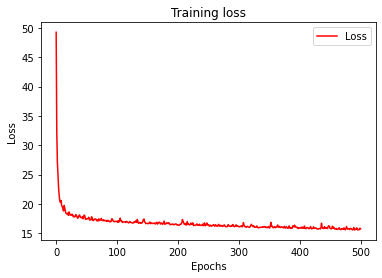

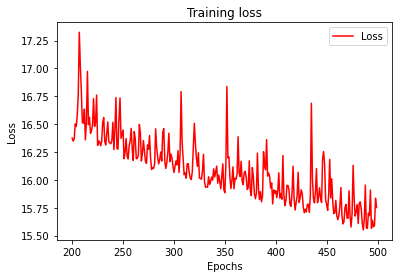

<Figure size 432x288 with 0 Axes>

In [27]:
# — — — — — — — — — — — — — — — — — — — — — — — — — — — — — -
# Retrieve a list of list results on training and test data
# sets for each training epoch
# — — — — — — — — — — — — — — — — — — — — — — — — — — — — — -
loss=history.history["loss"]
epochs=range(len(loss)) # Get number of epochs
# — — — — — — — — — — — — — — — — — — — — — — — — 
# Plot training and validation loss per epoch
# — — — — — — — — — — — — — — — — — — — — — — — — 
plt.plot(epochs, loss, "r")
plt.title("Training loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])
plt.figure()

zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)
# — — — — — — — — — — — — — — — — — — — — — — — — 
# Plot training and validation loss per epoch
# — — — — — — — — — — — — — — — — — — — — — — — — 
plt.plot(zoomed_epochs, zoomed_loss, "r")
plt.title("Training loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])
plt.figure()

In [28]:
def plot_series(x, y):
    plt.figure(figsize=(10, 6))
    
    plt.plot(x, y)
    plt.show()

<Figure size 720x432 with 0 Axes>

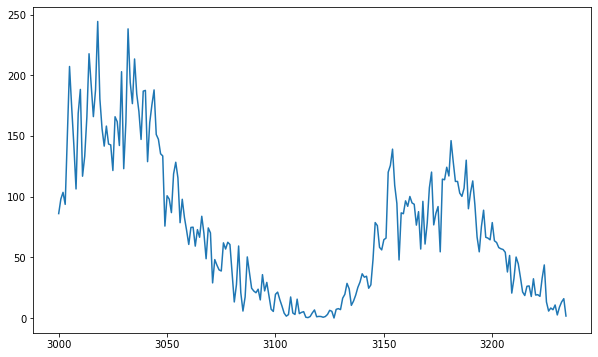

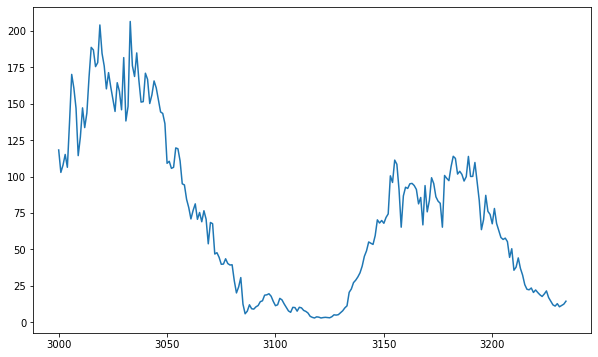

In [33]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    
    forecast = model.predict(ds)
    
    return forecast

rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)